In [32]:
%pip install -q --force-reinstall airavata-python-sdk[notebook]
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_gpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC1:cloud,expanse:shared,anvil:shared
%switch_runtime hpc_gpu

zsh:1: no matches found: airavata-python-sdk[notebook]
Note: you may need to restart the kernel to use updated packages.


Output()

Authenticated.

Runtime=hpc_gpu already exists!
Switched to runtime=hpc_gpu.


In [38]:
!pip install GPUtil

⠏ Connecting to=hpc_gpu... status=CONNECTED


In [39]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from collections import defaultdict
import time
import psutil
from datetime import datetime

class TrainingLogger(keras.callbacks.Callback):
    def __init__(self, log_path="training_metrics.csv"):
        super().__init__()
        self.log_path = log_path
        # write header
        header = [
            "timestamp","epoch","loss","accuracy",
            "val_loss","val_accuracy",
            "cpu_percent","mem_used_mb","mem_total_mb"
        ]
        pd.DataFrame([header]).to_csv(self.log_path, index=False, header=False)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        ts = datetime.now().isoformat()

        cpu = psutil.cpu_percent()
        vm = psutil.virtual_memory()
        mem_used = vm.used / 1024**2
        mem_total = vm.total / 1024**2

        row = {
            "timestamp": ts,
            "epoch": epoch,
            "loss": logs.get("loss"),
            "accuracy": logs.get("accuracy"),
            "val_loss": logs.get("val_loss"),
            "val_accuracy": logs.get("val_accuracy"),
            "cpu_percent": cpu,
            "mem_used_mb": round(mem_used,1),
            "mem_total_mb": round(mem_total,1),
        }
        pd.DataFrame([row]).to_csv(self.log_path, mode="a", index=False, header=False)


def fetch_multiple_seasons(season_years):
    all_games = []
    for season in season_years:
        print(f"Fetching season {season}…")
        gf = leaguegamefinder.LeagueGameFinder(
            season_nullable=season,
            season_type_nullable="Regular Season"
        )
        games = gf.get_data_frames()[0]
        all_games.append(games)
        time.sleep(1)
    return pd.concat(all_games, ignore_index=True)

def aggregate_team_stats(games):
    team_stats = defaultdict(lambda: {
        'points_scored':0,'points_allowed':0,'games':0,'wins':0
    })
    for _, g in games.iterrows():
        t, m, pts, res = g['TEAM_NAME'], g['MATCHUP'], g['PTS'], g['WL']
        opp = m.split('vs.')[-1] if 'vs.' in m else m.split('@')[-1]
        opp_row = games[
            (games['TEAM_ABBREVIATION']==opp)&
            (games['GAME_ID']==g['GAME_ID'])
        ]
        opp_pts = opp_row.iloc[0]['PTS'] if not opp_row.empty else np.nan
        team_stats[t]['points_scored']   += pts
        team_stats[t]['points_allowed']  += opp_pts if not np.isnan(opp_pts) else 0
        team_stats[t]['games']           += 1
        team_stats[t]['wins']            += (res=='W')
    for t, s in team_stats.items():
        gp = s['games']
        s['ppg']    = s['points_scored']/gp if gp else 0
        s['oppg']   = s['points_allowed']/gp   if gp else 0
        s['win_pct']= s['wins']/gp if gp else 0
    return pd.DataFrame.from_dict(team_stats, orient='index')

def create_real_matchups(ts_df, n=10000):
    X, y, teams = [], [], ts_df.index.tolist()
    if not teams: raise RuntimeError("No teams!")
    for _ in range(n):
        t1, t2 = np.random.choice(teams,2,False)
        s1, s2 = ts_df.loc[t1], ts_df.loc[t2]
        feat = [s1['ppg'],s1['oppg'],s1['win_pct'],
                s2['ppg'],s2['oppg'],s2['win_pct']]
        X.append(feat)
        y.append(1 if (s1['ppg']-s2['oppg'])>(s2['ppg']-s1['oppg']) else 0)
    return np.array(X), np.array(y)

def build_model(inp_shape):
    m = keras.Sequential([
        keras.layers.Dense(128,activation='relu',input_shape=inp_shape),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128,activation='relu'),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    m.compile('adam','binary_crossentropy',['accuracy'])
    return m

if __name__=='__main__':
    seasons = ['2020-21','2021-22','2022-23']
    games   = fetch_multiple_seasons(seasons)
    stats   = aggregate_team_stats(games)
    X, y    = create_real_matchups(stats)
    Xtra, Xte, ytr, yte = train_test_split(X,y, test_size=0.2, random_state=42)
    model   = build_model((Xtra.shape[1],))

    logger = TrainingLogger(log_path="training_metrics.csv")
    history = model.fit(
        Xtra, ytr,
        epochs=30,
        batch_size=32,
        validation_data=(Xte, yte),
        callbacks=[logger]
    )

    loss, acc = model.evaluate(Xte,yte)
    print(f"Test accuracy: {acc:.3f}")


⠇ Connecting to=hpc_gpu... status=CONNECTED
Fetching season 2020-21…
Fetching season 2021-22…
Fetching season 2022-23…
Epoch 1/30
250/250 [==============================] - 1s 2ms/step - loss: 1.2255 - accuracy: 0.5310 - val_loss: 0.6851 - val_accuracy: 0.5140
Epoch 2/30
250/250 [==============================] - 0s 1ms/step - loss: 0.6809 - accuracy: 0.6074 - val_loss: 0.4638 - val_accuracy: 0.9140
Epoch 3/30
250/250 [==============================] - 0s 1ms/step - loss: 0.4698 - accuracy: 0.7699 - val_loss: 0.1918 - val_accuracy: 0.9205
Epoch 4/30
250/250 [==============================] - 0s 1ms/step - loss: 0.2252 - accuracy: 0.9084 - val_loss: 0.1134 - val_accuracy: 0.9485
Epoch 5/30
250/250 [==============================] - 0s 1ms/step - loss: 0.1738 - accuracy: 0.9271 - val_loss: 0.0816 - val_accuracy: 0.9925
Epoch 6/30
250/250 [==============================] - 0s 1ms/step - loss: 0.1300 - accuracy: 0.9479 - val_loss: 0.0869 - val_accuracy: 0.9605
Epoch 7/30
250/250 [=========

In [40]:
!pip install matplotlib

⠏ Connecting to=hpc_gpu... status=CONNECTED


⠇ Connecting to=hpc_gpu... status=CONNECTED
timestamp  epoch      loss  accuracy  val_loss  \
0  2025-04-27T05:16:02.760085      0  1.225528  0.531000  0.685142   
1  2025-04-27T05:16:03.080699      1  0.680930  0.607375  0.463762   
2  2025-04-27T05:16:03.403289      2  0.469838  0.769875  0.191808   
3  2025-04-27T05:16:03.726437      3  0.225199  0.908375  0.113404   
4  2025-04-27T05:16:04.044148      4  0.173772  0.927125  0.081629   

   val_accuracy  cpu_percent  mem_used_mb  mem_total_mb  
0        0.5140          1.2       2264.0       60266.9  
1        0.9140          9.6       2266.2       60266.9  
2        0.9205          9.4       2264.4       60266.9  
3        0.9485         10.6       2266.4       60266.9  
4        0.9925         10.1       2264.4       60266.9


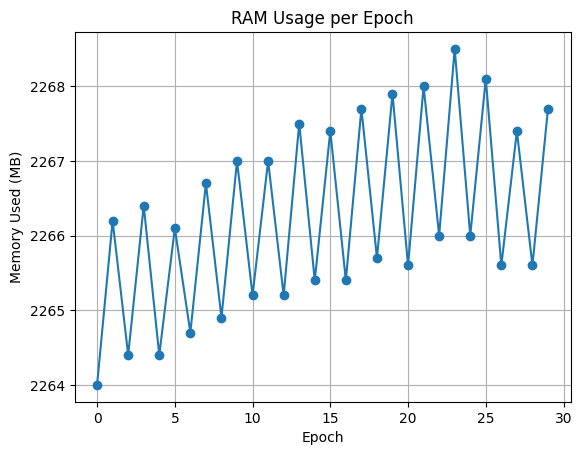

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Read the log
df = pd.read_csv("training_metrics.csv")

# 2. Inspect first few rows
print(df.head())

# 3. Plot memory used over epochs
plt.figure()
plt.plot(df["epoch"], df["mem_used_mb"], marker='o')
plt.xlabel("Epoch")
plt.ylabel("Memory Used (MB)")
plt.title("RAM Usage per Epoch")
plt.grid(True)
plt.show()
